# Comparison of output of BNT to Opexebo

This notebook will compare the output of BNT to the newer Python library (Opexebo) in order to verify that analyses have been transcribed directly. This will also serve to check that method calls make sens and do not require excessive manipulation to generate the expected inputs

A set of approximately 100 sessions has been inserted into the provisional Datajoint klusta pipeline.

In [1]:
import os
import datetime
import importlib
from tqdm import tqdm
import datajoint as dj
import scipy.io as spio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import ndimage
from skimage import measure, morphology
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,6]

In [2]:
os.chdir("C:\\Users\\simoba\\Documents\\_work\\Kavli\\GitHub\\opexebo")
# This is a hack to speed up importing Astropy. 
# Clearly, a better solution is needed in the long term, though
os.environ['HOMESHARE'] = r'C:\temp\astropy'
import opexebo

In [3]:
bnt_output = r'C:\Users\simoba\Documents\_work\Kavli\bntComp\Output_2\auto_input_file_vars.mat'
#bnt_output = r'N:\simoba\opexebo_working_area\test_data\non-square\input_file_vars.mat'
bnt = spio.loadmat(bnt_output)
bntAllStats = ['Path', 'Basename', 'Tetrode', 'Cell', 'Border Score', 'Coherence', 'field Main', 'Grid Score', 'Grid Stats - Ellipse Theta', 'Grid Stats - Ellipse', 'Grid Stats - Orientation', 'Grid Stats - Spacing', 'HD peak', 'Information Content', 'Information Rate', 'Mean Direction', 'Mean Rate outside fields', 'Mean Rate', 'Mean Vector Length', 'Number of Fields','Peak Rate', 'Selectivity', 'Sparsity', 'Speed Score']


## BNT Output Structure

ScreeningByTemplate generates a long list of figures, oddly in .jpg format, and a monolithic .mat file. 
Once opened by python, the .mat file contains the following. In general, values inside dictionaries are numpy arrays, even when they are storing a single-valued item (e.g. a float or a string)
```python
f = spio.loadmat(bnt_output)
f['cellsData'] : np.ndarray : Nx1
    [n,0] : dict
        ['unitLabel'] : str
        ['trialID'] : int
        ['epochs'] : np.ndarray
            [0,0] : np.ndarray (1x1)
                [0,0] : np.ndarray (1x1)
                    [0,0] : np.void (but behaves like a dict)
                        ['label'][0] : str
                        ['spikes'][i,0] : float
                        ['pos'][j,:] : array of floats (t, x, y)
                        ['spikes2Pos']
                        ['spikes2PosInd']
                        ['map']
                            [0,0]
                                ['x'] : np.ndarray 1xP+1
                                ['y'] : np.ndarray 1xP+1
                                ['count'] : np.ndarray PxP
                                ['time'] : np.ndarray PxP
                                ['z'] : np.ndarray PxP
                                ['Nspikes'] : np.ndarray PxP
                                ['zRaw'] : np.ndarray PxP
                                ['countRaw'] : np.ndarray PxP
                                ['timeRaw'] : np.ndarray PxP
                                ['peakRate'][0,0] : float
                        ['aCorr']
                        ['hdValues']
                        ['hdAngles_deg']
                        ['hdTrajectoryRaw']
                        ['borderScore']
                        ['coherence']
                        ['fieldMain']
                        ['gridScore']
                        ['gridStats_EllipseTheta'][0,0][0,0] : float
                        ['gridStats_Ellipse'][0,0][0,:] : np.ndarray
                        ['gridStats_Orientation'][0,0][:,0] : np.ndarray
                        ['gridStats_Spacing'][0,0][:,0] : np.ndarray
                               3 element array
                        ['hdPeakRate']
                        ['informationContent']
                        ['informationRate']
                        ['meanDirection']
                        ['meanRateOutsideFields']
                        ['meanRate']
                        ['mvl'][0,0] : float
                        ['numFields']
                        ['peakDirection']
                        ['peakRate']
                        ['selectivity']
                        ['sparsity']
                        
f['speedPopulation'] : np.ndarray : Mx1
f['sfrPopulations'] : np.ndarray : Mx1
f['allStatistics'] : np.ndarray : 1xN
    [0,i]
f['allFields'] : np.ndarray : 1xQ
    [0,i] : np.void
        ['Path'][0]
        ['Basename'][0]
        ['Tetrode'][0,0]
        ['Cell'][0,0]
        ['FieldNumber'][0,0]
        ['InFieldRate'][0,0]
        ['FieldSizeCm2'][0,0]
        
```

In [8]:
# Helper functions
importlib.reload(opexebo)
def get_details(i):
    path = bnt['allStatistics'][0,i]['Path'][0]
    basename = bnt['allStatistics'][0,i]['Basename'][0]
    tetrode = bnt['allStatistics'][0,i]['Tetrode'][0,0]
    cell = bnt['allStatistics'][0,i]['Cell'][0,0]
    description = {"path":path, "basename":basename, "tetrode":tetrode, "cell":cell}
    return description

def get_bnt_size():
    return bnt['allStatistics'].size
def rms(vals):
    sq = np.square(vals)
    sq = np.ma.masked_invalid(sq)
    me = np.mean(sq)
    rt = np.sqrt(me)
    return rt

def get_gridstats_bnt(i):
    spacing = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['gridStats_Spacing'][0,0][:,0]
    orient = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['gridStats_Orientation'][0,0][:,0]
    el = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['gridStats_Ellipse'][0,0][:,0]
    elth = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['gridStats_EllipseTheta'][0,0][:,0]
    return el, elth, spacing, orient

def get_speedscore_bnt(i):
    return bnt['allStatistics'][0,i][-1][0,0]

def get_fields_bnt(i):
    # Rely on cellsData and allStatistics being in the same order
    # get the identifying information from allStats
    path = bnt['allStatistics'][0,i]['Path'][0]
    basename = bnt['allStatistics'][0,i]['Basename'][0]
    tetrode = bnt['allStatistics'][0,i]['Tetrode'][0,0]
    cell = bnt['allStatistics'][0,i]['Cell'][0,0]
    
    fi = []
    for j in range(bnt['allFields'].size): # start no sooner than i - this assumes that a ratemap NEVER has zero fields
        pathj = bnt['allFields'][0,j]['Path'][0]
        basenamej = bnt['allFields'][0,j]['Basename'][0]
        tetrodej = bnt['allFields'][0,j]['Tetrode'][0,0]
        cellj = bnt['allFields'][0,j]['Cell'][0,0]
        if path == pathj and basename == basenamej and tetrode == tetrodej and cell == cellj:
            fi.append(j)
    return fi
    

def get_speeds_bnt(key):
    positions = bnt['cellsData'][key,0]['epochs'][0,0][0,0][0,0]['pos'].transpose()
    positions = np.ma.masked_where(np.isnan(positions), positions)
    t = positions[0,:]
    x = positions[1,:]
    y = positions[2,:]
    delta_t = np.append(np.diff(t), np.diff(t)[-1])
    delta_x = np.append(np.diff(x), np.diff(x)[-1])
    delta_y = np.append(np.diff(y), np.diff(y)[-1])
    s = np.sqrt(np.square(delta_x) + np.square(delta_y)) / delta_t
    return np.array([t, s])

def get_spiketimes_bnt(i):
    return bnt['cellsData'][i,0]['epochs'][0,0][0,0][0,0]['spikes'][:,0]
    
def get_ratemapstats_bnt(i):
    out1 = {'coherence':bnt['cellsData'][i,0]['epochs'][0,0][0,0]['coherence'][0,0][0,0],
           'sparsity':bnt['cellsData'][i,0]['epochs'][0,0][0,0]['sparsity'][0,0][0,0],
           'selectivity':bnt['cellsData'][i,0]['epochs'][0,0][0,0]['selectivity'][0,0][0,0],
           'informationContent':bnt['cellsData'][i,0]['epochs'][0,0][0,0]['informationContent'][0,0][0,0],
           'informationRate':bnt['cellsData'][i,0]['epochs'][0,0][0,0]['informationRate'][0,0][0,0]}
    out2 = np.array([ bnt['cellsData'][i,0]['epochs'][0,0][0,0]['informationRate'][0,0][0,0], 
                     bnt['cellsData'][i,0]['epochs'][0,0][0,0]['informationContent'][0,0][0,0],
                     bnt['cellsData'][i,0]['epochs'][0,0][0,0]['sparsity'][0,0][0,0],
                     bnt['cellsData'][i,0]['epochs'][0,0][0,0]['selectivity'][0,0][0,0],
                     bnt['cellsData'][i,0]['epochs'][0,0][0,0]['coherence'][0,0][0,0] ])
    return (out1, out2)
    
def get_dj_key(i):
    # Based on the data in the output .mat file, construct a key to the Ephys
    # Klusta pipeline. It's much easier to do it this way around, since DJ is
    # designed to be searched by values, while the .mat file is only indexed
    als = bnt['allStatistics'][0, i]
    path = als[0][0]
    date = os.path.split(path)[1] 
    animal_id = os.path.split(os.path.split(path)[0])[1]
    drive_user = os.path.split(os.path.split(os.path.split(path)[0])[0])[1]
    param_name = 'params_%s'%drive_user    
    session = als[1][0]
    tetrode = str(als[2][0,0])
    cell = als[3][0,0]    
    key = {'animal_id': animal_id,
          'drive_user':drive_user,
           #'session_timestamp':session_ts,
           'param_name':param_name,
          'tetrode':tetrode,
          'cluster':cell,
          'session':session,}
    return key

def get_time_map_dj(key, src='dj', ars = 80):
    if type(ars)==int:
        lim = (-ars/2, ars/2, -ars/2, ars/2)
    elif type(ars) in (tuple, list, np.ndarray):
        lim = (-ars[0]/2, ars[0]/2, -ars[1]/2, ars[1]/2)
    if src=='dj':
        ts = (behavior.Tracking & key).fetch1()
        t = ts['time_stamps']
        x = ts['x1']
        y = ts['y1']
        s = ts['speed_filtered']
        positions = np.array([t, x, y])
        print(positions.shape)
        speeds = np.array( [t, s] )    
    elif src=='bnt':
        positions=bnt['cellsData'][key,0]['epochs'][0,0][0,0][0,0]['pos'].transpose()
        positions = np.ma.masked_where(np.isnan(positions), positions)
        speeds = np.ones((2, positions.shape[1]))
    biw = 2.0
    spc = 0
    ma = opexebo.analysis.spatialoccupancy(positions, speeds, arena_size=ars, 
                                           bin_width=biw, speed_cutoff=spc, limits=lim)
    return ma

def get_time_map_bnt(i):
    t = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['map'][0,0]['time'][0,0]
    tr = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['map'][0,0]['timeRaw'][0,0]
    return t, tr

def get_spikes_bnt(i):
    spikes = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['spikes2Pos'][0,0]
    return spikes

def get_ratemap_bnt(i):
    z = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['map'][0,0]['z'][0,0]
    zr = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['map'][0,0]['zRaw'][0,0]
    nspikes = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['map'][0,0]['Nspikes'][0,0]
    #print("Spike count in BNT ratemap : %d" % np.sum(nspikes))
    return z, zr

def get_ratemap_opexebo(key, src, ars=80):
    if type(ars)==int:
        lim = (-ars/2, ars/2, -ars/2, ars/2)
    elif type(ars) in (tuple, list, np.ndarray):
        lim = (-ars[0]/2, ars[0]/2, -ars[1]/2, ars[1]/2)
    if src == 'dj':
        time_map = get_time_map_dj(key, src='bnt')
        spikes = get_spikes_bnt(key).T
    elif src == 'bnt':
        time_map = get_time_map_bnt(key)[1]
        spikes = get_spikes_bnt(key).T
    #print("Spike count into Opexebo: %d" % np.max(spikes.shape))
    biw = 2.0
    ars = 80
    ratemap = opexebo.analysis.ratemap(time_map, spikes, bin_width=biw, arena_size=ars, 
                                       limits=lim)
    return ratemap




# Place field detection
def get_fields_opexebo(key, src):
    if src=='dj':
        ratemap = get_ratemap_opexebo(key, 'bnt')
    if src=='bnt':
        ratemap = get_ratemap_bnt(key)[0]
    fields, fields_map = opexebo.analysis.placefield(ratemap)
    return fields, fields_map



# Grid Score
def get_gridness_score_bnt(i):
    score = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['gridScore'][0,0][0,0]
    return score
def get_acorr_bnt(i):
    acorr = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['aCorr'][0,0]
    return acorr
def get_acorr_opexebo(key, src='bnt'):
    z, zr = get_ratemap_bnt(key)
    acorr = opexebo.analysis.autocorrelation(z)
    return acorr
def get_gridness_score_opexebo(key, src):
    if src == 'dj':
        pass
    elif src == 'bnt':
        # Use the autocorrelogram stored in the output of BNT
        acorr = get_acorr_bnt(key)
        gs = opexebo.analysis.gridscore(acorr)
    elif src == 'bnt_min':
        # Construct au autocorrelogram using Python code as far as possible
        # i.e. starting from time/spike position in BNT output
        rmap = get_ratemap_opexebo(key, src='dj')
        rmap_smoothed = opexebo.general.smooth(rmap, sigma=2, mask_fill=0)
        acorr = opexebo.analysis.autocorrelation(rmap_smoothed)
        gs = opexebo.analysis.gridscore(acorr)
    return gs


# border score
def get_border_score_opexebo(key, src):
    if src == 'dj':
        pass
    elif src == 'bnt':
        rmap =  get_ratemap_bnt(key)[0]
        fields, fields_map = get_fields_opexebo(key, src='bnt')
        score = opexebo.analysis.borderscore(rmap, fields_map, fields, search_width=8, walls='trbl')
    return score

def get_border_score_bnt(i):
    score = bnt['cellsData'][i,0]['epochs'][0,0][0,0]['borderScore'][0,0][0,0]
    return score


In [9]:
get_details(100)

{'path': 'N:\\davidcr\\84932\\19032019',
 'basename': '19032019s1',
 'tetrode': 6,
 'cell': 23}

# Spatial Occupancy
Use the following functions:
```python
    opexebo.analysis.spatialoccupancy        
    opexebo.general.smoothing
```

### Check across all provided examples

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.341240801922233
0.341240801922233
0.341240801922233
0.341240801922233
0.341240801922233


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 93.15it/s]


Evaluating un-smoothed output of all time maps from BNT and Opexebo (5 units)
RMS of difference and ratio
Mean of RMS of difference: 1.8929e-03 (s)
Minimum, maximum RMS difference: [1.893, 1.893] (ms)
Mean of RMS of ratio: 1.0007e+00


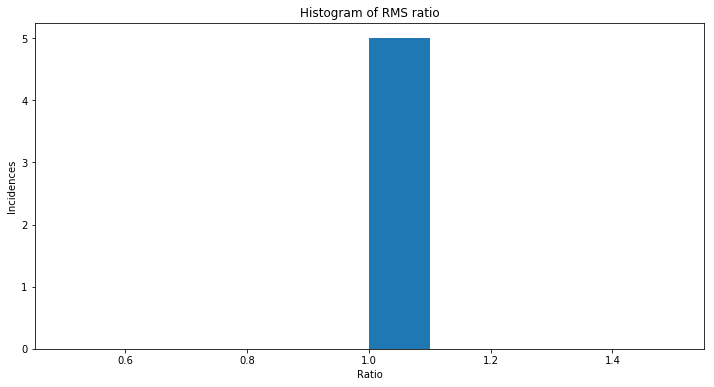

In [42]:
lim = get_bnt_size()
ratio = np.zeros(lim)
diff = np.zeros(lim)
for i in tqdm(range(lim)):
    t, tr = get_time_map_bnt(i)
    tr = np.ma.masked_invalid(tr)
    mar = get_time_map_dj(i, src='bnt', ars=(200,100))
    ratio[i] = rms(tr/mar)
    diff[i] = rms(tr-mar)

# Plot some graphs
plt.rcParams['figure.figsize'] = [12,6]
plt.hist(ratio)
plt.title("Histogram of RMS ratio")
plt.xlabel("Ratio")
plt.ylabel("Incidences")

# Print out some values
print("Evaluating un-smoothed output of all time maps from BNT and Opexebo (%d units)" % lim)
print("RMS of difference and ratio")
print("Mean of RMS of difference: %.4e (s)" % np.nanmean(diff))
print("Minimum, maximum RMS difference: [%.3f, %.3f] (ms)" % (np.min(diff)*1e3, np.max(diff)*1e3))
print("Mean of RMS of ratio: %.4e" % np.nanmean(ratio))

### Look at a single example 

Sum:  BNT: 1604.3; Op: 1604.3
Peak: BNT: 9.12; Op: 9.12
Ratio BNT/Opexebo: 
	mean  1.0000e+00, 
	RMS   1.0000e+00, 
	stdev 0.00e+00


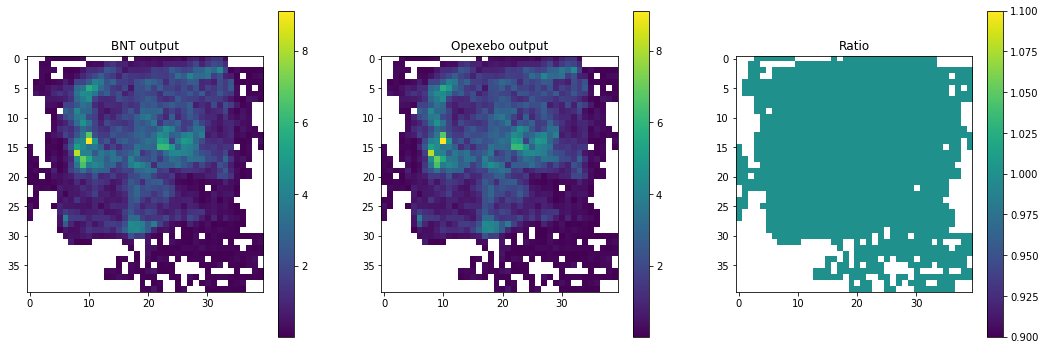

In [8]:
# Extract and calculate values
i = 10
t, tr = get_time_map_bnt(i)
mar = get_time_map_dj(i, src='bnt', ars=80)
ratio = tr/mar

# Plot some graphs showing the output
plt.rcParams['figure.figsize'] = [18,6]
plt.subplot(1,3,1)
plt.title("BNT output")
plt.imshow(tr)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Opexebo output")
plt.imshow(mar)
plt.colorbar()
plt.subplot(1,3,3)
plt.title("Ratio")
plt.imshow(ratio)
plt.colorbar()

# Print out some statistical values
print("Sum:  BNT: %.1f; Op: %.1f" % (np.nansum(tr), np.nansum(mar.data)))
print("Peak: BNT: %.2f; Op: %.2f" % (np.nanmax(tr), np.nanmax(mar)))
print("Ratio BNT/Opexebo: \n\tmean  %.4e, \n\tRMS   %.4e, \n\tstdev %.2e" % (np.nanmean(ratio), 
                                                                             rms(ratio), np.nanstd(ratio)))

### Now try smoothing

Sum:  BNT : 1334.8; Op: 1334.8
Peak: BNT: 4.67; Op: 4.67
Ratio RMS, 1.000, max 1.001


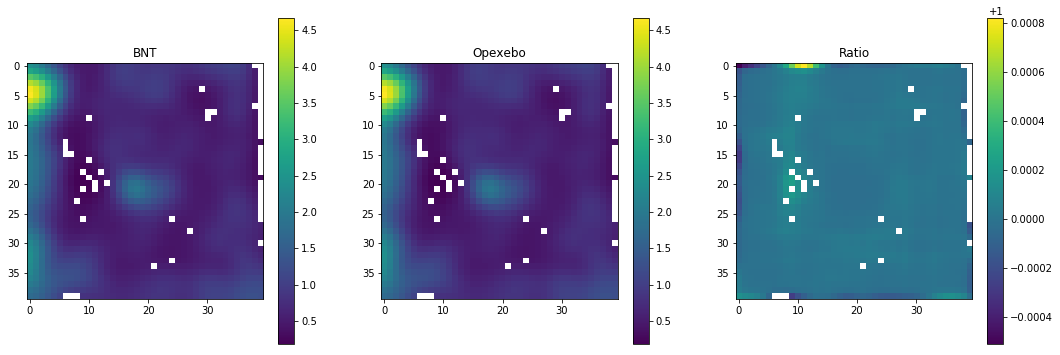

In [13]:
# Extract and calculate values
i = 430
t, tr = get_time_map_bnt(i)
mar = get_time_map_dj(i, src='bnt')
ma = opexebo.general.smooth(mar, sigma=2)
ratio = t/ma

# Plot some graphs
plt.rcParams['figure.figsize'] = [18,6]
plt.subplot(1,3,1)
plt.title("BNT")
plt.imshow(t)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Opexebo")
plt.imshow(ma)
plt.colorbar()
plt.subplot(1,3,3)
plt.title("Ratio")
plt.imshow(ratio)
plt.colorbar()


print("Sum:  BNT : %.1f; Op: %.1f" % (np.nansum(t), np.nansum(ma.data)))
print("Peak: BNT: %.2f; Op: %.2f" % (np.nanmax(t), np.nanmax(ma)))
print("Ratio RMS, %.3f, max %.3f" % (rms(ratio), np.nanmax(ratio)))


# Rate Map

Compare the ratemaps contained within the BNT output to the ratemap generated by opexebo. Consider both the ratemap generated from (occupancy_map_opexebo -> rate_map_opexebo) and (occupancy_map_BNT -> rate_map_opexebo)

In [ ]:
# Using the time map (map.timeRaw) and spike map (map.Nspikes) from BNT as the source, compare
# the appearance of rate maps

i = 53
rm_r = get_ratemap_opexebo(i, 'bnt')
rm = opexebo.general.smooth(rm_r, 2)
z, zr = get_ratemap_bnt(i)

print("Sum of opexebo Ratemap: %.1f" % np.nansum(rm_r))
print("Sum of BNT Ratemap: %.1f" % np.nansum(zr))

plt.subplot(1,2,1)
plt.imshow(zr)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(rm_r)
plt.colorbar()

In [ ]:
ratio = zr/rm_r
diff = zr-rm_r
plt.imshow(diff)
plt.colorbar()

In [ ]:
lim = get_bnt_size()
diff = np.zeros(lim)
diff_r = np.zeros(lim)
ratio = np.zeros(lim)
ratio_r = np.zeros(lim)
for i in tqdm(range(lim)):
    rm_r = get_ratemap_opexebo(i, 'bnt')
    rm = opexebo.general.smooth(rm_r, 2, mask_fill=0)
    z, zr = get_ratemap_bnt(i)
    
    d = rm_r-zr
    diff_r[i] = np.nanmean(d)
    d = rm-z
    diff[i] = np.nanmean(d)
    
    r = rm_r/zr
    ratio_r[i] = np.nanmean(r)
    r = rm/z
    ratio[i] = np.nanmean(r)

plt.hist(ratio, 40)
print("mean difference in raw ratemaps: %e" % np.nanmean(diff_r))
print("Stdev in difference in raw ratemapts : %e" % np.nanstd(diff_r))
print("mean difference in smoothed ratemaps: %e" % np.nanmean(diff))
print("Stdev in difference in smoothed ratemapts : %e" % np.nanstd(diff))
print("mean ratio in raw ratemaps: %e" % np.nanmean(ratio_r))
print("Stdev in ratio in raw ratemapts : %e" % np.nanstd(ratio_r))
print("mean ratio in smoothed ratemaps: %e" % np.nanmean(ratio))
print("Stdev in ratio in smoothed ratemapts : %e" % np.nanstd(ratio))

In [ ]:
# Compare rate map smoothing

i = 53
rm_r = get_ratemap_opexebo(i, 'bnt')
rm = opexebo.general.smooth(rm_r, 2, mask_fill=0)
z, zr = get_ratemap_bnt(i)

diff = (z - rm)
ratio = (z/rm)
print(np.min(ratio), np.max(ratio))

plt.subplot(1,2,1)
plt.imshow(ratio)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(rm)
plt.colorbar()
#

## Place Field detection

Test the functionality of Vadim's python adaptive place field detection

In [ ]:
i = 303
rmap_raw= get_ratemap_opexebo(i, 'bnt')
rmap = opexebo.general.smooth(rmap_raw, 2)
rmapd = np.array(rmap)
assert(rmapd.all() == rmap.data.all())

z, zr = get_ratemap_bnt(i)

plt.rcParams['figure.figsize'] = [18,6]
plt.subplot(1,3,1)
plt.title("Ratemap")
plt.imshow(rmap)
plt.colorbar()
plt.subplot(1,3,2)
#plt.title("BNT Ratemap")
plt.imshow(opexebo.analysis.placefield(z, min_mean=0.5)[1])
plt.colorbar()
plt.subplot(1,3,3)
#plt.title("Op Ratemap")
plt.imshow(opexebo.analysis.placefield(z)[1])
plt.colorbar()

## Border Score

Based on the provided place field detection, calculate border coverage and border score

In [ ]:
from scipy.ndimage import distance_transform_edt, distance_transform_cdt
def _weighted_firing_distance(rmap):
    '''
    parameters
    ---
    rmap    : np.ma.MaskedArray
        Rate map of cells inside fields. NxM array where cells inside fields
        give the firing rate, and cells outside fields are zero
    returns
    -------
    wfd     : float
        Weighted firing distance. 
    '''
    # Check that the provided array is properly masked
    if type(rmap != np.ma.MaskedArray):
        rmap = np.ma.masked_invalid(rmap)
        
    # Normalise firing map by the sum of the firing map, such that it resembles a PDF
    rmap /= np.ma.sum(rmap)
    
    # Create an array, same size as rmap, where the cell value is the distance (in bins) from the edge of the array:
    x = np.ones(rmap.shape) # define area same size as ratemap
    x = np.pad(x, 1, mode='constant') # Pad outside with zeros, we calculate distance from nearest zero
    dist = distance_transform_cdt(x, metric='taxicab') # taxicab metric: distance along axes, not diagonal distance. 
    #wfd = np.ma.sum( np.ma.dot(dist[1:-1, 1:-1], rmap) )
    wfd = np.ma.sum( dist[1:-1, 1:-1] * rmap )
    
    # Normalise by half of the smallest arena dimensions
    wfd = 2 * wfd / np.min(rmap.shape)
    return wfd


i = 303
rmap_raw= get_ratemap_opexebo(i, 'bnt')
rmap = opexebo.general.smooth(rmap_raw, 2)


fields, field_map = opexebo.analysis.placefield(rmap, min_mean=0.5)
fmap = field_map.copy()
sw = 8
walls = 't'
if walls == 'l':
    aux_map = fmap[:,:sw]
elif walls == 'r':
    aux_map = np.fliplr(fmap[:, -sw:])
elif walls == 'b':
    aux_map = np.rot90(fmap[:sw, :])
elif walls == 't':
    aux_map = np.fliplr(np.rot90(fmap[-sw:, :]))

aux_map[aux_map>1] = 1
distance = distance_transform_edt(1-aux_map)

plt.rcParams['figure.figsize'] = [18,6]
plt.subplot(1,4,1)
plt.title("Ratemap")
plt.imshow(rmap)
plt.colorbar()
plt.subplot(1,4,2)
plt.title("Op Place Fields")
plt.imshow(field_map)
plt.colorbar()
plt.subplot(1,4,3)
plt.title(walls)
plt.imshow(aux_map)
plt.subplot(1,4,4)
plt.title("distance")
plt.imshow(distance)

num_fields = bnt['cellsData'][i,0]['epochs'][0,0][0,0][0,0]['numFields'][0,0]
bs_bnt = get_border_score_bnt(i)
bs_op = opexebo.analysis.borderscore(rmap, field_map, fields, search_width=sw, walls=walls)
#bs_op = opexebo.analysis.bordercoverage(fields, search_width=sw, walls=walls)
wfd = _weighted_firing_distance(rmap)

print("BNT: %d fields" % num_fields)
print("Ope: %d fields" % len(fields))
print("BNT: %.3f BS" % bs_bnt)
print("Ope: %.9f BS" % bs_op)
wfd

In [ ]:
lim = get_bnt_size()
bs_bnt = np.zeros(lim)
bs_op = np.zeros(lim)
for i in tqdm(range(lim)):    
    bs_bnt[i] = get_border_score_bnt(i)
    bs_op[i] = get_border_score_opexebo(i, 'bnt')
fig, ax = plt.subplots(1,1)
fit = (np.nanmin(bs_bnt), np.nanmax(bs_bnt))
ax.plot(bs_bnt, bs_op, 'b.')
ax.plot(fit, fit, 'r-')
ax.set_xlabel('Border Score: BNT')
ax.set_ylabel('Border Score: Opexebo')
np.sum(np.isnan(bs_bnt))

## Putting everything together : GridScore

Each individual stage to grid score seems to work very well - when we get take the n-1th stage from the BNT ouput, process it with Python, and compare it to the nth stage from BNT output.

What happens when we take the earliest stage from BNT, run it entirely through python, and then compare the final stage with the BNT output?

In [48]:
def all_in_one(i, ars=80):
    binwidth = 2.0
    speedcutoff = 2.0
    if type(ars)==int:
        lim = (-ars/2, ars/2, -ars/2, ars/2)
    elif type(ars) in (tuple, list, np.ndarray):
        lim = (-ars[0]/2, ars[0]/2, -ars[1]/2, ars[1]/2)
    
    # Get positions from BNT
    time_map_raw = get_time_map_dj(i, src='bnt', ars=ars)
    time_map = opexebo.general.smooth(time_map_raw, sigma=2, mask_fill=0)
    
    # get spike positions from BNT:
    spikes = get_spikes_bnt(i).T
    
    #Calculate a raw ratemap
    
    ratemap_raw = opexebo.analysis.ratemap(time_map_raw, spikes, bin_width=binwidth, arena_size=ars, limits=lim)
    
    # Smooth the ratemap
    sigma = 2
    mf = 0
    ratemap = opexebo.general.smooth(ratemap_raw, sigma, mask_fill = mf)
    
    # Generate an autocorrelogram
    acorr = opexebo.analysis.autocorrelation(ratemap)
    
    # Calculate a gridscore
    gs, grid_stats = opexebo.analysis.gridscore(acorr)
    
    # Calculate statistics about the RateMap
    rate, content, sparsity, selectivity= opexebo.analysis.ratemapstats(ratemap, time_map)
    coherence = opexebo.analysis.ratemapcoherence(ratemap_raw)
    rm_stats = rate, content, sparsity, selectivity, coherence
    
    
    out = {'time_map':time_map_raw, 'spikes': spikes, 'rmap_raw':ratemap_raw, 'rmap':ratemap, 'acorr':acorr, 'gs':gs,'rmstats':rm_stats, 'gstats':grid_stats}
    return out

RMS difference in time map: 1.8929e-03 s
RMS difference in raw ratemap: 2.8807e-12 Hz
RMS difference in smoothed ratemap: 5.2869e-05 Hz
RMS difference in aCorr: 4.7520e-05
PyNT: 1.3693 :: BNT: 1.3693


Text(0,0.5,'BNT')

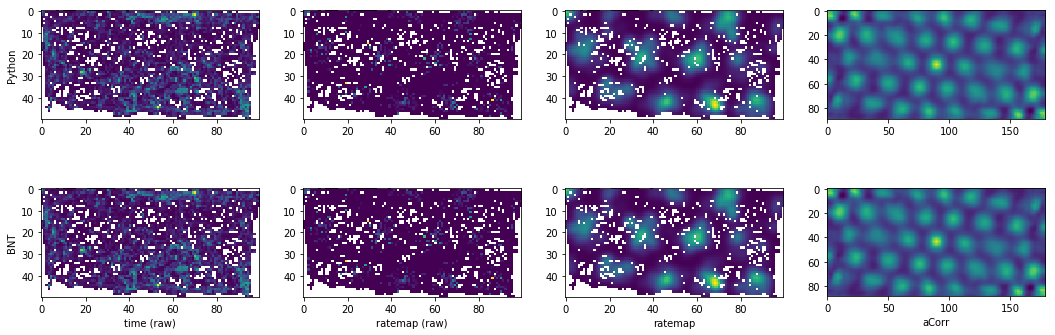

In [49]:
i = 0
out = all_in_one(i, ars=(200,100))

# Verify that the time map is accurate
tr = get_time_map_bnt(i)[1]
print("RMS difference in time map: %.4e s" % rms(tr - out['time_map']))

# Verify that the ratemap (raw and smoothed) are accurate
z, zr = get_ratemap_bnt(i)
print("RMS difference in raw ratemap: %.4e Hz" % rms(zr - out['rmap_raw']))
print("RMS difference in smoothed ratemap: %.4e Hz" % rms(z - out['rmap']))

# Verify that the autocorrelogorams are accurate
acorr = get_acorr_bnt(i)
print("RMS difference in aCorr: %.4e" % rms(acorr - out['acorr']))

# Verify that Grid score is equivalent
gs = get_gridness_score_bnt(i)
print("PyNT: %.4f :: BNT: %.4f" % (out['gs'], gs))

fig, ax = plt.subplots(2,4)
ax[0,0].imshow(out['time_map'])
ax[0,1].imshow(out['rmap_raw'])
ax[0,2].imshow(out['rmap'])
ax[0,3].imshow(out['acorr'])

ax[1,0].imshow(tr)
ax[1,1].imshow(zr)
ax[1,2].imshow(z)
ax[1,3].imshow(acorr)

ax[1,0].set_xlabel("time (raw)")
ax[1,1].set_xlabel("ratemap (raw)")
ax[1,2].set_xlabel("ratemap")
ax[1,3].set_xlabel("aCorr")
ax[0,0].set_ylabel("Python")
ax[1,0].set_ylabel("BNT")

### Gridscore correlation between BNT and Python

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.98it/s]


0

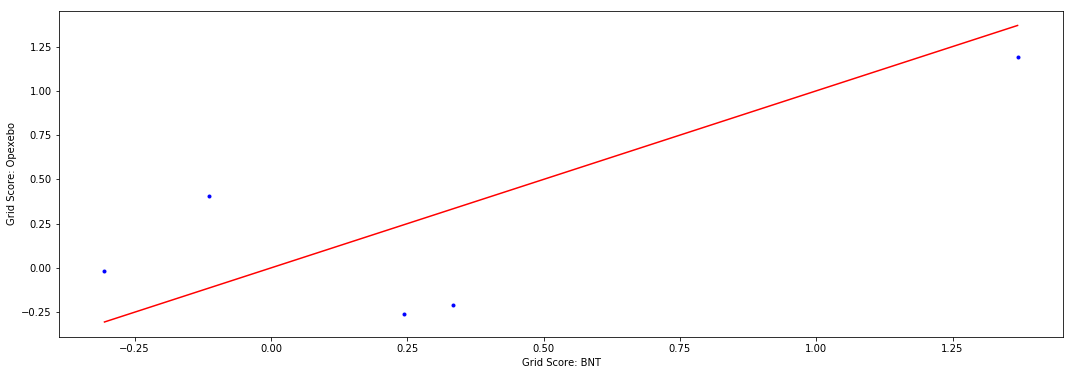

In [50]:
lim = get_bnt_size()
gs_bnt = np.zeros(lim)
gs_op = np.zeros(lim)
for i in tqdm(range(lim)):    
    gs_bnt[i] = get_gridness_score_bnt(i)
    gs_op[i] = all_in_one(i)['gs']
fig, ax = plt.subplots(1,1)
fit = (np.nanmin(gs_bnt), np.nanmax(gs_bnt))
ax.plot(gs_bnt, gs_op, 'b.')
ax.plot(fit, fit, 'r-')
ax.set_xlabel('Grid Score: BNT')
ax.set_ylabel('Grid Score: Opexebo')
np.sum(np.isnan(gs_bnt))

### Ratemap stats correlation between BNT, Python

In [22]:
lim = get_bnt_size()
s_bnt = np.zeros((lim, 5))
s_op = np.zeros((lim, 5))
for i in tqdm(range(lim)):
    s_bnt[i,:] = get_ratemapstats_bnt(i)[1]
    s_op[i,:] = all_in_one(i)['rmstats']
    #s_op[i,4] = coherence(i)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.08it/s]


rate : nan
content : nan
sparsity : nan
selectivity : nan
coherence : nan


Text(0,0.5,'Python')

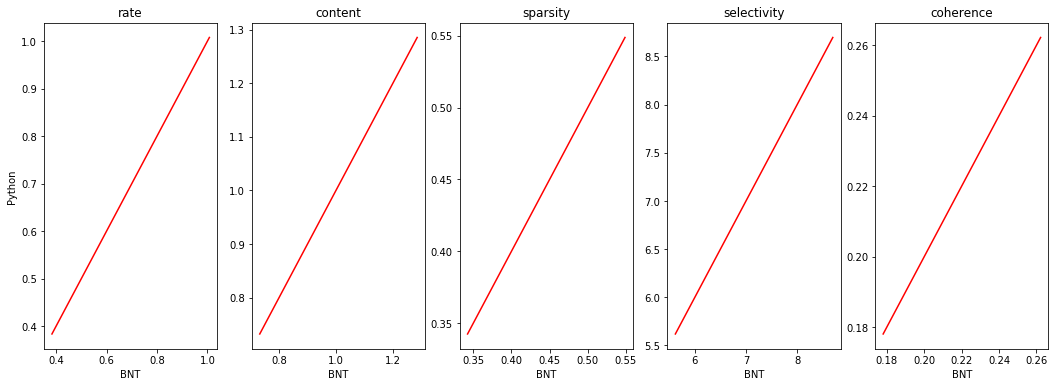

In [23]:
t = 5
labels = ['rate', 'content', 'sparsity', 'selectivity', 'coherence']
plt.rcParams['figure.figsize'] = [18,6]
fig, ax = plt.subplots(1,t)
for i in range(t):
    fit = (np.min(s_bnt[:,i]), np.max(s_bnt[:,i]))    
    ax[i].plot(s_bnt[:,i], s_op[:,i], 'b.')
    ax[i].plot(fit, fit, 'r-')
    ax[i].set_title(labels[i])
    ax[i].set_xlabel('BNT')
    c = np.corrcoef(np.array([s_bnt[:,i], s_op[:,i]]), rowvar=1)[0,1]
    print("%s : %.3f" % (labels[i], c))
ax[0].set_ylabel('Python')


### Grid Stats between BNT, PyNT

In [24]:
labels = ['ellipse', 'ellipse_theta', 'spacing', 'orientation']
lim = get_bnt_size()
lim = int(lim/1)
s_bnt = np.zeros(lim)
spacing_bnt = np.zeros((lim,3))
orr_bnt = np.zeros((lim,3))
ell_bnt = []
s_op = np.zeros(lim)
spacing_op = np.zeros((lim, 3))
orr_op = np.zeros((lim,3))
ell_op = []
#lim = 2
for i in tqdm(range(lim)):
    gsb = get_gridstats_bnt(i)
    s_bnt[i] = gsb[1]
    spacing_bnt[i,:] = gsb[2]
    orr_bnt[i] = gsb[3]
    ell_bnt.append(gsb[0])
    gsod = all_in_one(i)['gstats']
    gso = [gsod['ellipse'], gsod['ellipse_theta'], gsod['spacing'], gsod['orientation']]
    s_op[i] = gsod['ellipse_theta']
    spacing_op[i,:] = gsod['spacing']
    orr_op[i,:] = gsod['orientation']
    ell_op.append(gsod['ellipse'])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


C:\Users\simoba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in remainder
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\simoba\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in remainder


Text(0.5,0,'BNT')

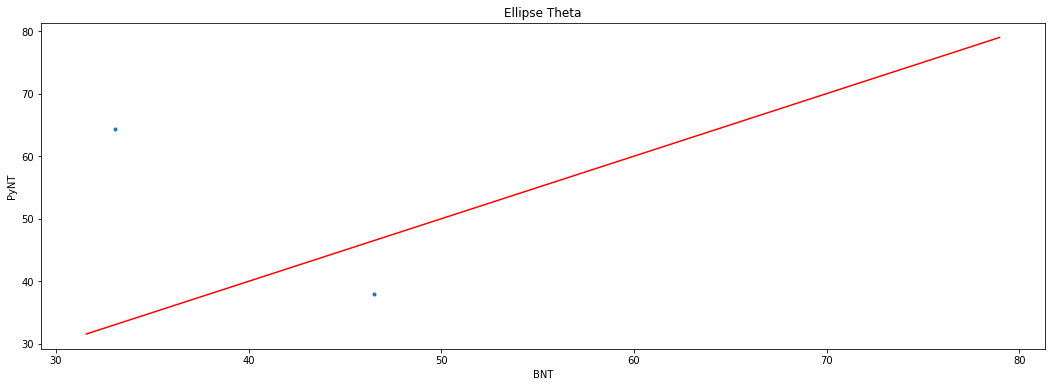

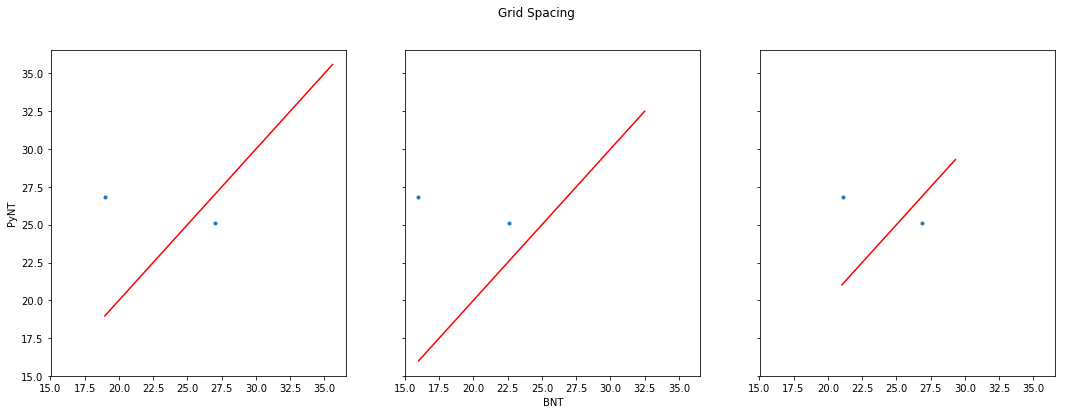

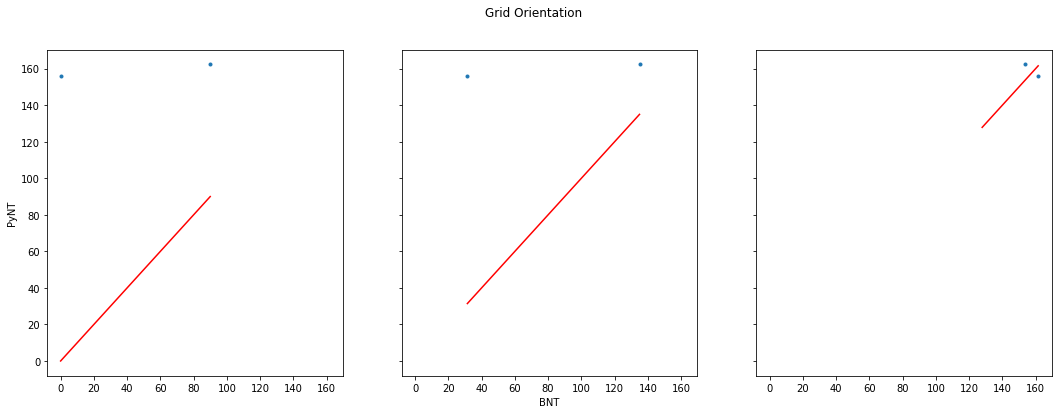

In [25]:
plt.rcParams['figure.figsize'] = [18,6]
etb = s_bnt%90
eto = s_op%90
# Ellipse Theta
fig, ax = plt.subplots(1,1)
fit = (np.nanmin(etb), np.nanmax(etb)) 
ax.plot(fit, fit, 'r-')
ax.plot(etb, eto, '.')
ax.set_xlabel("BNT")
ax.set_ylabel("PyNT")
ax.set_title("Ellipse Theta")
# Spacing
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
fig.suptitle("Grid Spacing")
for i in range(3):
    fit = (np.nanmin(spacing_bnt[:,i]), np.nanmax(spacing_bnt[:,i]))
    ax[i].plot(fit, fit, 'r')
    ax[i].plot(spacing_bnt[:,i], spacing_op[:,i], '.')
ax[0].set_ylabel("PyNT")
ax[1].set_xlabel("BNT")
# Orientation
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
fig.suptitle("Grid Orientation")
# The below manipulation arises from the question over, for each pair of points, which point was preserved. 
# If BNT preserved one in [0,180], but OP preserved [-180, 0], there is a problem. This is visible in a 
# correlation along a line 180° above/below the red line, but it's still weak
# However, since the results are sorted by value, the +- question really screws it up
# So wrap *both* into [0,180], and then resort (along the axis containing 3 values), and bingo.
orr_bnt = orr_bnt%180
orr_op = orr_op%180
orr_bnt = np.sort(orr_bnt, axis=1)
orr_op = np.sort(orr_op, axis=1)

for i in range(3):
    fit = (np.nanmin(orr_bnt[:,i]), np.nanmax(orr_bnt[:,i]))
    ax[i].plot(fit, fit, 'r')
    ax[i].plot(orr_bnt[:,i], orr_op[:,i], '.')
ax[0].set_ylabel("PyNT")
ax[1].set_xlabel("BNT")

In [10]:
for i in range(lim):
    ell = ell_op[i]
    z = 0.001
    try:
        if abs(ell[0] - 35) > z and abs(ell[1] - 35) > z:
            print(i)
    except:
        pass
        
    

In [7]:
from astropy.convolution import convolve
def coherence(i):
    rate_map = get_ratemap_bnt(i)[1] # Use the raw ratemap, not the smoothed one
    kernel = np.array([[0.125, 0.125, 0.125],
                      [0.125, 0,     0.125],
                      [0.125, 0.125, 0.125]])

    
    avg_map = convolve(rate_map, kernel, 'fill', fill_value=0)
    avg_map = np.nan_to_num(avg_map)
    #plt.subplot(1,2,2) 
    #plt.imshow(avg_map)
    avg_map = avg_map.ravel()
    
    
    rmap = np.copy(rate_map)
    rmap = np.nan_to_num(rmap)
    #plt.subplot(1,2,1)
    #plt.imshow(rmap)
    rmap = rmap.reshape(rmap.size)
    

    
    #c = np.corrcoef(np.array([avg_map, rmap]), rowvar=1)[0,1]
    c = np.corrcoef(avg_map, rmap)[0,1]
    return c

In [ ]:
np.unravel_index([], (40,40), 'F')